In [1]:
#importing python libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
from itertools import chain
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve, train_test_split
from sklearn.metrics import precision_score, recall_score, confusion_matrix, roc_curve, precision_recall_curve, accuracy_score
import warnings
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff


In [2]:
#read data
data = pd.read_csv('breastcancer.csv')


In [3]:
#misssing values
null_feat = pd.DataFrame(len(data['id']) - data.isnull().sum(), columns = ['Count'])

trace = go.Bar(x = null_feat.index, y = null_feat['Count'] ,opacity = 0.6, marker=dict(color = '#0000FF',
        line=dict(color='#FA8072',width=1.5)))

layout = dict(title =  "Missing Values")
                    
fig = dict(data = [trace], layout=layout)
py.iplot(fig)

In [4]:
# Drop useless variables
data = data.drop(['Unnamed: 32','id'],axis = 1)

# Reassign target
data.diagnosis.replace(to_replace = dict(M = 1, B = 0), inplace = True)

In [5]:
data.head()

diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0          1        17.99         10.38          122.80     1001.0   
1          1        20.57         17.77          132.90     1326.0   
2          1        19.69         21.25          130.00     1203.0   
3          1        11.42         20.38           77.58      386.1   
4          1        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   symmetry_mean  ...  radius_worst  texture_worst  perimeter_worst  \
0         0.2419  ...         25.38          17.33           184.60   
1         0.1812  ...         24.99          23.41           158.80   
2         0.2069  ...         23.57          25.53           152.50   
3         0.2597  ...         14.91          26.50            98.87   
4         0.1809  ...         22.54          16.67           152.20   

   area_worst  smoothness_worst  compactness_worst  concavity_worst  \
0      2019.0            0.1622             0.6656           0.7119   
1      1956.0            0.1238             0.1866           0.2416   
2      1709.0            0.1444             0.4245           0.4504   
3       567.7            0.2098             0.8663           0.6869   
4      1575.0            0.1374             0.2050           0.4000   

   concave points_worst  symmetry_worst  fractal_dimension_worst  
0                0.2654          0.4601                  0.11890  
1                0.1860          0.2750                  0.08902  
2                0.2430          0.3613                  0.08758  
3                0.2575          0.6638                  0.17300  
4                0.1625          0.2364                  0.07678  

[5 rows x 31 columns]

In [6]:
data.skew()

diagnosis                  0.528461
radius_mean                0.942380
texture_mean               0.650450
perimeter_mean             0.990650
area_mean                  1.645732
smoothness_mean            0.456324
compactness_mean           1.190123
concavity_mean             1.401180
concave points_mean        1.171180
symmetry_mean              0.725609
fractal_dimension_mean     1.304489
radius_se                  3.088612
texture_se                 1.646444
perimeter_se               3.443615
area_se                    5.447186
smoothness_se              2.314450
compactness_se             1.902221
concavity_se               5.110463
concave points_se          1.444678
symmetry_se                2.195133
fractal_dimension_se       3.923969
radius_worst               1.103115
texture_worst              0.498321
perimeter_worst            1.128164
area_worst                 1.859373
smoothness_worst           0.415426
compactness_worst          1.473555
concavity_worst            1

In [30]:
# Review your data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    int64  
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

In [8]:
data.columns

Index(['diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

In [10]:
#describe data
data.describe()

diagnosis  radius_mean  texture_mean  perimeter_mean    area_mean  \
count  569.000000   569.000000    569.000000      569.000000   569.000000   
mean     0.372583    14.127292     19.289649       91.969033   654.889104   
std      0.483918     3.524049      4.301036       24.298981   351.914129   
min      0.000000     6.981000      9.710000       43.790000   143.500000   
25%      0.000000    11.700000     16.170000       75.170000   420.300000   
50%      0.000000    13.370000     18.840000       86.240000   551.100000   
75%      1.000000    15.780000     21.800000      104.100000   782.700000   
max      1.000000    28.110000     39.280000      188.500000  2501.000000   

       smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
count       569.000000        569.000000      569.000000           569.000000   
mean          0.096360          0.104341        0.088799             0.048919   
std           0.014064          0.052813        0.079720             0.038803   
min           0.052630          0.019380        0.000000             0.000000   
25%           0.086370          0.064920        0.029560             0.020310   
50%           0.095870          0.092630        0.061540             0.033500   
75%           0.105300          0.130400        0.130700             0.074000   
max           0.163400          0.345400        0.426800             0.201200   

       symmetry_mean  ...  radius_worst  texture_worst  perimeter_worst  \
count     569.000000  ...    569.000000     569.000000       569.000000   
mean        0.181162  ...     16.269190      25.677223       107.261213   
std         0.027414  ...      4.833242       6.146258        33.602542   
min         0.106000  ...      7.930000      12.020000        50.410000   
25%         0.161900  ...     13.010000      21.080000        84.110000   
50%         0.179200  ...     14.970000      25.410000        97.660000   
75%         0.195700  ...     18.790000      29.720000       125.400000   
max         0.304000  ...     36.040000      49.540000       251.200000   

        area_worst  smoothness_worst  compactness_worst  concavity_worst  \
count   569.000000        569.000000         569.000000       569.000000   
mean    880.583128          0.132369           0.254265         0.272188   
std     569.356993          0.022832           0.157336         0.208624   
min     185.200000          0.071170           0.027290         0.000000   
25%     515.300000          0.116600           0.147200         0.114500   
50%     686.500000          0.131300           0.211900         0.226700   
75%    1084.000000          0.146000           0.339100         0.382900   
max    4254.000000          0.222600           1.058000         1.252000   

       concave points_worst  symmetry_worst  fractal_dimension_worst  
count            569.000000      569.000000               569.000000  
mean               0.114606        0.290076                 0.083946  
std                0.065732        0.061867                 0.018061  
min                0.000000        0.156500                 0.055040  
25%                0.064930        0.250400                 0.071460  
50%                0.099930        0.282200                 0.080040  
75%                0.161400        0.317900                 0.092080  
max                0.291000        0.663800                 0.207500  

[8 rows x 31 columns]

In [31]:
# 2 datasets
M = data[(data['diagnosis'] != 0)]
B = data[(data['diagnosis'] == 0)]

In [25]:
M

diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0            1        17.99         10.38          122.80     1001.0   
1            1        20.57         17.77          132.90     1326.0   
2            1        19.69         21.25          130.00     1203.0   
3            1        11.42         20.38           77.58      386.1   
4            1        20.29         14.34          135.10     1297.0   
..         ...          ...           ...             ...        ...   
563          1        20.92         25.09          143.00     1347.0   
564          1        21.56         22.39          142.00     1479.0   
565          1        20.13         28.25          131.20     1261.0   
566          1        16.60         28.08          108.30      858.1   
567          1        20.60         29.33          140.10     1265.0   

     smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0            0.11840           0.27760         0.30010              0.14710   
1            0.08474           0.07864         0.08690              0.07017   
2            0.10960           0.15990         0.19740              0.12790   
3            0.14250           0.28390         0.24140              0.10520   
4            0.10030           0.13280         0.19800              0.10430   
..               ...               ...             ...                  ...   
563          0.10990           0.22360         0.31740              0.14740   
564          0.11100           0.11590         0.24390              0.13890   
565          0.09780           0.10340         0.14400              0.09791   
566          0.08455           0.10230         0.09251              0.05302   
567          0.11780           0.27700         0.35140              0.15200   

     symmetry_mean  ...  radius_worst  texture_worst  perimeter_worst  \
0           0.2419  ...         25.38          17.33           184.60   
1           0.1812  ...         24.99          23.41           158.80   
2           0.2069  ...         23.57          25.53           152.50   
3           0.2597  ...         14.91          26.50            98.87   
4           0.1809  ...         22.54          16.67           152.20   
..             ...  ...           ...            ...              ...   
563         0.2149  ...         24.29          29.41           179.10   
564         0.1726  ...         25.45          26.40           166.10   
565         0.1752  ...         23.69          38.25           155.00   
566         0.1590  ...         18.98          34.12           126.70   
567         0.2397  ...         25.74          39.42           184.60   

     area_worst  smoothness_worst  compactness_worst  concavity_worst  \
0        2019.0            0.1622             0.6656           0.7119   
1        1956.0            0.1238             0.1866           0.2416   
2        1709.0            0.1444             0.4245           0.4504   
3         567.7            0.2098             0.8663           0.6869   
4        1575.0            0.1374             0.2050           0.4000   
..          ...               ...                ...              ...   
563      1819.0            0.1407             0.4186           0.6599   
564      2027.0            0.1410             0.2113           0.4107   
565      1731.0            0.1166             0.1922           0.3215   
566      1124.0            0.1139             0.3094           0.3403   
567      1821.0            0.1650             0.8681           0.9387   

     concave points_worst  symmetry_worst  fractal_dimension_worst  
0                  0.2654          0.4601                  0.11890  
1                  0.1860          0.2750                  0.08902  
2                  0.2430          0.3613                  0.08758  
3                  0.2575          0.6638                  0.17300  
4                  0.1625          0.2364                  0.07678  
..                    .

In [13]:
#------------COUNT-----------------------
trace = go.Bar(x = (len(M), len(B)), y = ['malignant', 'benign'], orientation = 'h', opacity = 0.8, marker=dict(
        color=[ '#4682B4', '#EE82EE'],
        line=dict(color='#B22222',width=1.5)))

layout = dict(title =  'Count of diagnosis variable')
                    
fig = dict(data = [trace], layout=layout)
py.iplot(fig)

#------------PERCENTAGE-------------------
trace = go.Pie(labels = ['benign','malignant'], values = data['diagnosis'].value_counts(), 
               textfont=dict(size=15), opacity = 0.8,
               marker=dict(colors=['#4682B4', '#EE82EE'], 
                           line=dict(color='#B22222', width=1.5)))


layout = dict(title =  'Distribution of diagnosis variable')
           
fig = dict(data = [trace], layout=layout)
py.iplot(fig)

In [34]:
def histogram(data_select, size_bin):  
    tmp1 = M[data_select]
    tmp2 = B[data_select]
    hist_data = [tmp1, tmp2]
    
    group_labels = ['malignant', 'benign']
    colors = ['orange', 'green']

    fig = ff.create_distplot(hist_data, group_labels, colors = colors, show_hist = True, bin_size = size_bin, curve_type='kde')
    
    fig['layout'].update(title = data_select)
    
    
    plt.title('Density plot')
    py.iplot(fig)

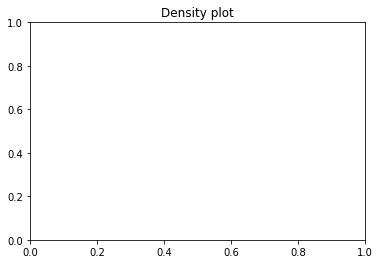

In [36]:
#histogram distribution 'mean'
histogram('radius_mean', .5)
histogram('texture_se', .1)
histogram('perimeter_se', .5)
histogram('area_se', 5)
histogram('smoothness_se', .5)
histogram('compactness_se', .5)
histogram('concavity_se', .5)
histogram('concave points_se', .5)
histogram('symmetry_se', .5)
histogram('fractal_dimension_se', .5)


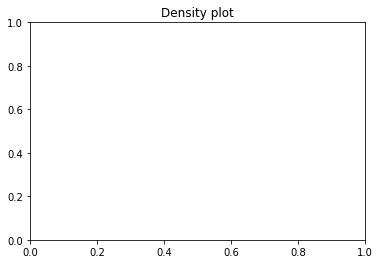

In [37]:
#histogram distribution 'se'
histogram('radius_se', .1)
histogram('texture_se', .1)
histogram('perimeter_se', .5)
histogram('area_se', 5)
histogram('smoothness_se', .5)
histogram('compactness_se', .5)
histogram('concavity_se', .5)
histogram('concave points_se', .5)
histogram('symmetry_se', .5)
histogram('fractal_dimension_se', .5)

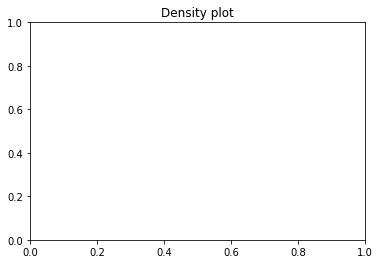

In [38]:
#histogram distribution 'worst'
histogram('radius_worst', .5)
histogram('texture_worst', .5)
histogram('perimeter_worst', 5)
histogram('area_worst', 10)
histogram('smoothness_worst', .5)
histogram('compactness_worst', .5)
histogram('concavity_worst', .5)
histogram('concave points_worst', .5)
histogram('symmetry_worst', .5)
histogram('fractal_dimension_worst', .5)

In [41]:
#correlation
correlation = data.corr()
#tick labels
matrix_cols = correlation.columns.tolist()
#convert to array
corr_array  = np.array(correlation)